## Load Document

In [7]:
import os
from docx import Document
import pdfplumber


def openFile(file_name):
    if file_name.endswith('.txt'):
        with open(file_name, 'r') as txt_file:
            isi_file = txt_file.read()

    elif file_name.endswith('.docx'):
        doc = Document(file_name)
        isi_file = ''
        for paragraph in doc.paragraphs:
            isi_file += (paragraph.text + "\n")

    elif file_name.endswith('.pdf'):
        isi_file = ''
        with pdfplumber.open(file_name) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                isi_file += (text + "\n")

    else:
        print("Format Dokumen Tidak Tersedia")

    return isi_file


In [9]:
dokumen_1 = openFile('Artikel 1.txt')
dokumen_2 = openFile('Artikel 2.pdf')

In [ ]:
print(f"dokumen 1 :\n\n {dokumen_1}")

In [ ]:
print(f"dokumen 2 :\n\n {dokumen_2}")

## Test Dummy

In [159]:
'''test test'''

# dokumen_1 = 'Manajemen waktu adalah keterampilan kunci yang harus dimiliki oleh setiap individu, baik dalam konteks pekerjaan maupun kehidupan pribadi. Kemampuan untuk mengatur dan memanfaatkan waktu dengan efisien adalah faktor penentu kesuksesan dalam mencapai tujuan. Dengan manajemen waktu yang baik, kita dapat meningkatkan produktivitas, mengurangi stres, dan meningkatkan kualitas hidup secara keseluruhan. Itulah mengapa penting untuk memberikan perhatian serius terhadap manajemen waktu dalam setiap aspek kehidupan kita.'
# dokumen_2 = 'Manajemen waktu adalah keterampilan esensial dalam kehidupan sehari-hari. Dengan mengatur waktu dengan baik, Anda dapat meningkatkan produktivitas, menghindari stres berlebih, dan mencapai tujuan Anda lebih efisien. Terutama dalam dunia yang penuh dengan tuntutan, keterampilan ini memungkinkan Anda untuk menjaga keseimbangan antara pekerjaan, keluarga, dan waktu pribadi. Dengan manajemen waktu yang baik, Anda dapat merencanakan tugas-tugas dengan bijak, menghindari prokrastinasi, dan memiliki lebih banyak waktu untuk mengejar hobi serta bersantai. Akhirnya, manajemen waktu yang efektif adalah kunci untuk menciptakan kualitas hidup yang lebih baik secara keseluruhan.'


## Preprocessing

In [160]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download("stopwords")
stopword = nltk.corpus.stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [161]:
alphabet = "([A-Za-z])"
akronim = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
angka = "([0-9])"
url = "[.](com|net|org|io|gov|id|co|COM|CO|edu|me)"
gelar = "(Mr|Mrs|Ms|Dr|dr|Prof|Capt|Cpt)"
gelar2 = "(Pd|Sp)"
singkatan = "(dkk|No)"
awalan = "(vitamin|Gen|Generasi)"


def document_to_sentence_list(text):
    text = text.replace("/n", "<pisah> ")
    text = text.replace("\n", "<pisah> ")

    # inisialisasi tanda titik yang bukan merupakan akhir kalimat (<bak>)
    if "..." in text:
        text = text.replace("...", "<bak><bak><bak>")
    if "Ph.D" in text:
        text = text.replace("Ph.D.", "Ph<bak>D")

    text = text.replace("..", ".")
    # ganti tanda titik yang merupakan <bak> (bukan akhir kalimat)
    text = re.sub(url, "<bak>\\1", text)
    text = re.sub(awalan + "\s" + alphabet + "[.] ", "\\1 \\2<pisah>", text)
    text = re.sub(angka + "[.]" + angka, "\\1<bak>\\2", text)
    text = re.sub("\s" + angka + "[.] ", " \\1<bak> ", text)
    text = re.sub("\s" + gelar + "[.]", " \\1<bak>", text)
    text = re.sub("\s" + alphabet + "[.]" +
                  gelar2 + "[.]", " \\1<bak>\\2<bak>", text)
    text = re.sub("\s" + gelar2 + "[.]" +
                  alphabet + "[.]", " \\1<bak>\\2<bak>", text)
    text = re.sub("\s" + singkatan + "[.]", " \\1<bak>", text)
    text = re.sub(alphabet + "[.]" + alphabet, "\\1<bak>\\2", text)
    text = re.sub(alphabet + "[.]" + alphabet + "[.]" +
                  alphabet + "[.]", "\\1<bak>\\2<bak>\\3<bak>", text)
    text = re.sub(alphabet + "[.]" + alphabet +
                  "[.]", "\\1<bak>\\2<bak>", text)
    text = re.sub(" " + alphabet + "[.]", " \\1<bak>", text)
    if '"' in text:
        text = text.replace('."', '".')
    text = re.sub("[?]" + " ([a-z])", "<bak2>\\1", text)
    text = re.sub("[!]" + " ([a-z])", "<bak3>\\1", text)
    text = re.sub("[?]" + '" ([a-z])', "<bak2>\\1", text)
    text = re.sub("[!]" + '" ([a-z])', "<bak3>\\1", text)
    if "?" in text:
        text = text.replace('?",', '<bak2>",')

    # tandai pemisah kalimat
    text = text.replace(".", ".<pisah>")
    text = text.replace("?", "?<pisah>")
    text = text.replace("!", "!<pisah>")

    # ubah <ba>k menjadi tanda titik lagi
    text = text.replace("<bak>", ".")
    text = text.replace("<bak2>", "? ")
    text = text.replace("<bak3>", "! ")

    # pecah kalimat berdasarkan penanda <pisah>
    kumpulan_kalimat = text.split("<pisah>")

    # masukkan kalimat dalam list_kalimat
    kumpulan_kalimat = kumpulan_kalimat[:-1]
    list_kalimat = [kalimat.strip() for kalimat in kumpulan_kalimat]

    return list_kalimat


In [162]:
def cleaning(list_kalimat):
    hasil = []
    for kalimat in list_kalimat:
        kalimat = re.sub(r'\w*\d+\w*', '', kalimat)  # hapus nomer
        kalimat = re.sub(r'[^\w\s]', ' ', kalimat)  # hapus tandabaca
        kalimat = re.sub(r'<[^<]+?>', '', kalimat)  # hapus enter
        kalimat = re.sub(r'\s{2,}', ' ', kalimat)  # hapus spasi berlebih
        kalimat = kalimat.replace('\n', ' ')
        kalimat = re.sub(r'\s+', ' ', kalimat)
        hasil.append(kalimat)
    return hasil


def case_folding(list_kalimat):
    hasil = [kalimat.lower() for kalimat in list_kalimat]
    return hasil


def stemming(list_kalimat):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    hasil = [stemmer.stem(kalimat) for kalimat in list_kalimat]
    return hasil


def tokenizing(list_kalimat):
    hasil = []
    for kalimat in list_kalimat:
        kalimat = re.split(' ', kalimat)
        hasil.append(kalimat)
    return hasil


def stopwords(list_kalimat):
    hasil = []
    for kalimat in list_kalimat:
        text = [kata for kata in kalimat if kata not in stopword]
        hasil.append(text)
    return hasil


def untokenize(dokumen):
    text = ' '.join(dokumen)
    step1 = text.replace("`` ", '"').replace(
        " ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    return step4


In [163]:
def preprocessing(document):
    list_kalimat = document_to_sentence_list(document)
    list_kalimat_cleaning = cleaning(list_kalimat)
    list_kalimat_casfol = case_folding(list_kalimat_cleaning)
    list_kalimat_stem = stemming(list_kalimat_casfol)
    list_kalimat_per_kata = tokenizing(list_kalimat_stem)
    list_kalimat_nostopword = stopwords(list_kalimat_per_kata)
    list_kalimat_per_kata_prepro = [
        x for x in list_kalimat_nostopword if x != [''] if x != []]

    list_kalimat_prepro = [untokenize(n) for n in list_kalimat_per_kata_prepro]

    index_kosong = []
    for i in range(len(list_kalimat_nostopword)):
        if list_kalimat_nostopword[i] == ['']:
            index_kosong.append(i)
        if list_kalimat_nostopword[i] == []:
            index_kosong.append(i)

    '''List Kalimat tanpa index kosong'''
    list_kalimat_ = [list_kalimat[i]
                     for i in range(len(list_kalimat)) if i not in index_kosong]

    return list_kalimat_, list_kalimat_prepro, list_kalimat_per_kata_prepro


# Similarity Formulation

In [164]:
import math
import numpy as np

In [165]:
''' Mengumah kalimat atau text menjadi suatu list kata '''

def text_to_word_list(kalimat):
    list_kata = []
    for kata in kalimat:
        if kata not in list_kata:
            list_kata.append(kata)

    return list_kata


#### Jaccard Similarity

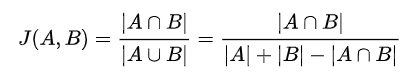

In [166]:
def jaccard_similarity(text1, text2):
    list_kata_text1 = text_to_word_list(text1)
    list_kata_text2 = text_to_word_list(text2)
    irisan = 0

    '''
    Menghitung kata yang sama (muncul pada kalimat1 dan muncul pada kalimat kalimat2)
    Mengabaikan adanya kata yang muncul 2 kali dalam satu kalimat (jika ada 2 kata sama tetep dinilai 1)
    |A ∩ B|
    '''

    for kata in list_kata_text1:
        if kata in list_kata_text2:
            irisan += 1

    '''|A∪B|'''
    gabungan = len(list_kata_text1) + len(list_kata_text2) - irisan

    if irisan == 0:
        similarity = 0
    if irisan != 0:
        similarity = irisan/gabungan

    return similarity


#### Cosine Similarity

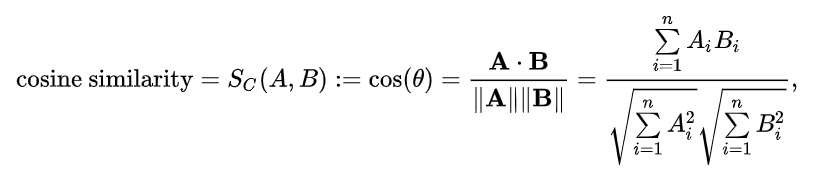

In [167]:
def cosine_similarity(matrix1, matrix2):
    similarity = np.zeros([len(matrix1), len(matrix2)])
    dot_product = 0
    sum_A_square = 0
    sum_B_square = 0

    for A, B in zip(matrix1, matrix2):
        AB = A*B
        dot_product += AB

        A_square = A**2
        B_square = B**2

        sum_A_square += A_square
        sum_B_square += B_square

    similarity = dot_product/math.sqrt(sum_A_square * sum_B_square)

    return similarity


##### BoW

In [168]:
def kalimat_list_kata(list_kalimat):
    list_kata = []
    for kalimat in list_kalimat:
        for kata in kalimat:
            if kata not in list_kata:
                list_kata.append(kata)
    return list_kata


def term_frequency_kalimat(list_kalimat, list_kata):
    list_tf = []
    for kalimat in list_kalimat:
        term_freq = {}
        for kata in list_kata:
            term_freq[kata] = 0
        for kata in kalimat:
            term_freq[kata] += 1
        list_tf.append(term_freq)
    return list_tf


def dict_to_matrix(dictionary):
    hasil = []
    for t in dictionary:
        values = list(t.values())
        hasil.append(values)
    return np.array(hasil)


def sentence_to_BOW_matrix(list_kalimat):
    list_kata = kalimat_list_kata(list_kalimat)
    TFK = term_frequency_kalimat(list_kalimat, list_kata)
    BOW_matrix = dict_to_matrix(TFK)
    return BOW_matrix


##### TFIDF

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer


def matrix_TFIDF_library(list_kalimat):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(list_kalimat)
    return tfidf_matrix


# Word-Level Comparison

In [170]:
kalimat_1, kalimat_prepro1, kalimat_token_prepro1 = preprocessing(dokumen_1)
kalimat_2, kalimat_prepro2, kalimat_token_prepro2 = preprocessing(dokumen_2)

In [171]:
def word_in_document(document):
    list_kata = []
    for kalimat in document:
        list_kata = list_kata + kalimat

    return list_kata


In [172]:
text__1 = word_in_document(kalimat_token_prepro1)
text__2 = word_in_document(kalimat_token_prepro2)

In [173]:
jaccard_similarity_kata = jaccard_similarity(text__1,text__2)
jaccard_similarity_kata

0.35714285714285715

In [174]:
BOW_matrix = sentence_to_BOW_matrix([text__1, text__2])

BOW_cosine_similarity = cosine_similarity(BOW_matrix[0],BOW_matrix[1])
BOW_cosine_similarity

0.6284186886676618

In [175]:
TFIDFLib_matrix = matrix_TFIDF_library([untokenize(kalimat_prepro1)] + [untokenize(kalimat_prepro2)])
TFIDFLib_matrix  = TFIDFLib_matrix.toarray()

TFIDFLib_cosine_similarity = cosine_similarity(TFIDFLib_matrix[0], TFIDFLib_matrix[1])
TFIDFLib_cosine_similarity

0.47695710906686384

# Sentence-Level Comparison

In [176]:
kalimat_1, kalimat_prepro1, kalimat_token_prepro1 = preprocessing(dokumen_1)
kalimat_2, kalimat_prepro2, kalimat_token_prepro2 = preprocessing(dokumen_2)

In [178]:
def matrix_jaccard_similarity(list_text1, list_text2):
  similarity = np.zeros([len(list_text1), len(list_text2)])
  for i in range(len(list_text1)):
    for j in range(len(list_text2)):
      kalimat1 = list_text1[i]
      kalimat2 = list_text2[j]

      similarity[i][j] = jaccard_similarity(kalimat1,kalimat2)
  return similarity

In [179]:
matrix_jaccard_similarity = matrix_jaccard_similarity(kalimat_token_prepro1, kalimat_token_prepro2)
matrix_jaccard_similarity

array([[0.3       , 0.        , 0.1875    , 0.11764706, 0.25      ],
       [0.        , 0.36363636, 0.        , 0.        , 0.        ],
       [0.25      , 0.27272727, 0.        , 0.06666667, 0.33333333],
       [0.25      , 0.        , 0.        , 0.06666667, 0.2       ]])

In [180]:
def matrix_cosine_similarity(matrix1, matrix2):
  similarity = np.zeros([len(matrix1), len(matrix2)])
  for i in range(len(matrix1)):
    for j in range(len(matrix2)):
      similarity[i][j] = cosine_similarity(matrix1[i], matrix2[j])

  return similarity

In [181]:
BOW_matrix_join = sentence_to_BOW_matrix(kalimat_token_prepro1 + kalimat_token_prepro2)

BOW_matrix1 = BOW_matrix_join[:len(kalimat_token_prepro1)]
BOW_matrix2 = BOW_matrix_join[len(kalimat_token_prepro1):]

matrix_BoW_cosine_sim = matrix_cosine_similarity(BOW_matrix1, BOW_matrix2)
matrix_BoW_cosine_sim

array([[0.5       , 0.        , 0.31622777, 0.18490007, 0.40824829],
       [0.        , 0.53452248, 0.        , 0.        , 0.        ],
       [0.33333333, 0.47140452, 0.        , 0.09245003, 0.40824829],
       [0.40824829, 0.        , 0.        , 0.1132277 , 0.33333333]])

In [182]:
TFIDF_matrix_join = matrix_TFIDF_library(kalimat_prepro1 + kalimat_prepro2)
TFIDF_matrix_join = TFIDF_matrix_join.toarray()
TFIDF_matrix1 = TFIDF_matrix_join[:len(kalimat_token_prepro1)]
TFIDF_matrix2 = TFIDF_matrix_join[len(kalimat_token_prepro1):]

matrix_tfidf_cosine_sim = matrix_cosine_similarity(TFIDF_matrix1, TFIDF_matrix2)
matrix_tfidf_cosine_sim

array([[0.3191751 , 0.        , 0.26808883, 0.11743611, 0.26817814],
       [0.        , 0.4937036 , 0.        , 0.        , 0.        ],
       [0.17473441, 0.50479227, 0.        , 0.03340087, 0.27757293],
       [0.19266382, 0.        , 0.        , 0.03682811, 0.14051445]])

# Hasil

In [183]:
import pandas as pd
pd.set_option('display.max_colwidth', True)

In [189]:
''' Word Level Comparison (antar kata dalam dokumen) '''
print("Hasil pada Word Level Comparison (antar kata dalam dokumen)\n")
print(f"Hasil komparasi dengan jaccard similarity       : {jaccard_similarity_kata}")
print(f"Hasil komparasi dengan BOW cosine similarity    : {BOW_cosine_similarity}")
print(f"Hasil komparasi dengan TFIDF cosine similarity  : {TFIDFLib_cosine_similarity}")

Hasil pada Word Level Comparison (antar kata dalam dokumen)

Hasil komparasi dengan jaccard similarity       : 0.35714285714285715
Hasil komparasi dengan BOW cosine similarity    : 0.6284186886676618
Hasil komparasi dengan TFIDF cosine similarity  : 0.47695710906686384


In [190]:
''' Sentence Level Comparison (antar kata dalam dokumen) '''
print("Hasil pada Sentence Level Comparison (antar kata dalam dokumen)\n")
print(f"Hasil komparasi dengan jaccard similarity      :\n{matrix_jaccard_similarity}\n")
print(f"Hasil komparasi dengan BOW cosine similarity   :\n{matrix_BoW_cosine_sim}\n")
print(f"Hasil komparasi dengan TFIDF cosine similarity :\n{matrix_tfidf_cosine_sim}\n")

Hasil pada Sentence Level Comparison (antar kata dalam dokumen)

Hasil komparasi dengan jaccard similarity      :
[[0.3        0.         0.1875     0.11764706 0.25      ]
 [0.         0.36363636 0.         0.         0.        ]
 [0.25       0.27272727 0.         0.06666667 0.33333333]
 [0.25       0.         0.         0.06666667 0.2       ]]

Hasil komparasi dengan BOW cosine similarity   :
[[0.5        0.         0.31622777 0.18490007 0.40824829]
 [0.         0.53452248 0.         0.         0.        ]
 [0.33333333 0.47140452 0.         0.09245003 0.40824829]
 [0.40824829 0.         0.         0.1132277  0.33333333]]

Hasil komparsi dengan TFIDF cosine similarity :
[[0.3191751  0.         0.26808883 0.11743611 0.26817814]
 [0.         0.4937036  0.         0.         0.        ]
 [0.17473441 0.50479227 0.         0.03340087 0.27757293]
 [0.19266382 0.         0.         0.03682811 0.14051445]]



In [186]:
''' Kalimat yang Paling mirip antara dokumen 1 dan dokumen 2 (TFIDF Cosine)'''

minimal_kemiripan = 0.3

data_conclussion = {'kalimat pada doc 1': [],
                    'kalimat pada doc 2': [],
                    'kemiripan': []}

df_conclussion = pd.DataFrame(data_conclussion)

for index1, item1 in enumerate(matrix_tfidf_cosine_sim):
    for index2, item2 in enumerate(item1):
        if matrix_tfidf_cosine_sim[index1][index2] > minimal_kemiripan:
            new_row = {'kalimat pada doc 1': kalimat_1[index1],
                       'kalimat pada doc 2': kalimat_2[index2],
                       'kemiripan': matrix_tfidf_cosine_sim[index1][index2]}
            new_df = pd.DataFrame([new_row])
            df_conclussion = pd.concat(
                [df_conclussion, new_df], ignore_index=True)

display(df_conclussion)


,kalimat pada doc 1,kalimat pada doc 2,kemiripan
0,"Manajemen waktu adalah keterampilan kunci yang harus dimiliki oleh setiap individu, baik dalam konteks pekerjaan maupun kehidupan pribadi.",Manajemen waktu adalah keterampilan esensial dalam kehidupan sehari-hari.,0.319175
1,Kemampuan untuk mengatur dan memanfaatkan waktu dengan efisien adalah faktor penentu kesuksesan dalam mencapai tujuan.,"Dengan mengatur waktu dengan baik, Anda dapat meningkatkan produktivitas, menghindari stres berlebih, dan mencapai tujuan Anda lebih efisien.",0.493704
2,"Dengan manajemen waktu yang baik, kita dapat meningkatkan produktivitas, mengurangi stres, dan meningkatkan kualitas hidup secara keseluruhan.","Dengan mengatur waktu dengan baik, Anda dapat meningkatkan produktivitas, menghindari stres berlebih, dan mencapai tujuan Anda lebih efisien.",0.504792


In [187]:
''' Hasil seluruh Kemiripan kalimat antara dokumen 1 dan dokumen 2'''

df = pd.DataFrame(matrix_tfidf_cosine_sim, columns=kalimat_2, index=kalimat_1)
display(df)

,Manajemen waktu adalah keterampilan esensial dalam kehidupan sehari-hari.,"Dengan mengatur waktu dengan baik, Anda dapat meningkatkan produktivitas, menghindari stres berlebih, dan mencapai tujuan Anda lebih efisien.","Terutama dalam dunia yang penuh dengan tuntutan, keterampilan ini memungkinkan Anda untuk menjaga keseimbangan antara pekerjaan, keluarga, dan waktu pribadi.","Dengan manajemen waktu yang baik, Anda dapat merencanakan tugas-tugas dengan bijak, menghindari prokrastinasi, dan memiliki lebih banyak waktu untuk mengejar hobi serta bersantai.","Akhirnya, manajemen waktu yang efektif adalah kunci untuk menciptakan kualitas hidup yang lebih baik secara keseluruhan."
"Manajemen waktu adalah keterampilan kunci yang harus dimiliki oleh setiap individu, baik dalam konteks pekerjaan maupun kehidupan pribadi.",0.319175,0.000000,0.268089,0.117436,0.268178
Kemampuan untuk mengatur dan memanfaatkan waktu dengan efisien adalah faktor penentu kesuksesan dalam mencapai tujuan.,0.000000,0.493704,0.000000,0.000000,0.000000
"Dengan manajemen waktu yang baik, kita dapat meningkatkan produktivitas, mengurangi stres, dan meningkatkan kualitas hidup secara keseluruhan.",0.174734,0.504792,0.000000,0.033401,0.277573
Itulah mengapa penting untuk memberikan perhatian serius terhadap manajemen waktu dalam setiap aspek kehidupan kita.,0.192664,0.000000,0.000000,0.036828,0.140514
